In [ ]:
pd.set_option('display.max_colwidth', 5000)

# Understanding Workplace Culture through Topic Modeling

<style>
    .header {
        color: white;
        background-color: #000B50;
        padding: 2px 0;
        font-size: 30px;
        text-align: center;
    }
    .sub-header {
        color: white;
        background-color: #2196F3;
        padding: 2px 0;
        font-size: 16px;
        text-align: center;
    }
</style>

## <div class="header">Goal</div>

The primary goal of this notebook is to leverage the capabilities of BERTopic to generate and analyze topics from a dataset consisting of 1600 comments related to workplace culture. These comments provide a rich source of qualitative data, reflecting various perspectives and experiences within workplace environments.

By applying topic modeling to this dataset, we aim to:
- **Discover underlying themes**: Identify and extract the main topics that emerge from the comments, which will help in understanding the common themes employees discuss in the context of workplace culture.
- **Improve insights with iteration**: After the initial topic modeling, we plan to review the topics generated, evaluate their relevance and coherence, and possibly subset the topics for a more focused analysis. This iterative approach will allow us to refine our understanding and gain deeper insights into specific aspects of workplace culture.
- **Enhance decision-making**: The insights derived from this analysis will aid in making informed decisions related to workplace policies, culture improvement initiatives, and employee engagement strategies.



<div class="sub-header">Approach</div>

We will closely follow BERTopic's documentation to ensure a structured and comprehensive understanding of its functionalities. This process will not only involve applying BERTopic to our dataset but also aim at building a foundational knowledge of topic modeling techniques, parameter tuning, and interpretation of results.

By the end of this notebook, we should be able to:
- Execute topic modeling on a real-world dataset.
- Interpret the topics and their relevance to workplace culture.
- Perform iterative analysis for refined insights.
- Apply learned concepts to future datasets or research areas involving qualitative data analysis.

Let's embark on this journey to explore the nuances of workplace culture through the lens of topic modeling.

<style>
    .header {
        color: white;
        background-color: #4CAF50;
        padding: 2px 0;
        font-size: 20px;
        text-align: center;
    }
    .sub-header {
        color: white;
        background-color: #2196F3;
        padding: 2px 0;
        font-size: 20px;
        text-align: center;
    }
</style>

<div class="header">The BERTopic Algorithm Overview</div>

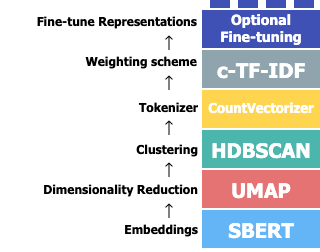
<p>This section provides a structured overview of the BERTopic algorithm, highlighting its steps and modular design for topic modeling.</p>

<div class="sub-header">Visual Overview</div>
<p>BERTopic's process is broken down into five main steps, forming a sequence that transforms raw text into coherent topic representations. These steps offer modularity, allowing for flexibility in how each part of the algorithm is approached. Specifically:</p>

<ul>
    <li><strong>Modularity:</strong> BERTopic's design ensures that each step, from tokenization to clustering, operates independently. This independence allows users to experiment with different sub-models or approaches within each step without affecting the overall topic modeling performance.</li>
    <li><strong>Tokenization and Embeddings:</strong> The tokenization step is decoupled from the embeddings model, providing freedom to choose any method for tokenization without dependency on the embedding technique used.</li>
    <li><strong>Clustering Flexibility:</strong> The algorithm's use of HDBSCAN for clustering accommodates various cluster shapes and sizes, avoiding reliance on centroid-based techniques. This is critical as centroid representations can misrepresent the diverse nature of textual data clusters.</li>
    <li><strong>Bag-of-Words Representation:</strong> By favoring a bag-of-words approach for topic representation, BERTopic makes minimal assumptions about the cluster's structure, enhancing its adaptability to different data characteristics.</li>
</ul>

<p>In summary, BERTopic stands out for its modular architecture, allowing for a high degree of customization in topic modeling. This modularity ensures that BERTopic remains versatile and effective across a wide array of datasets and user needs.</p>


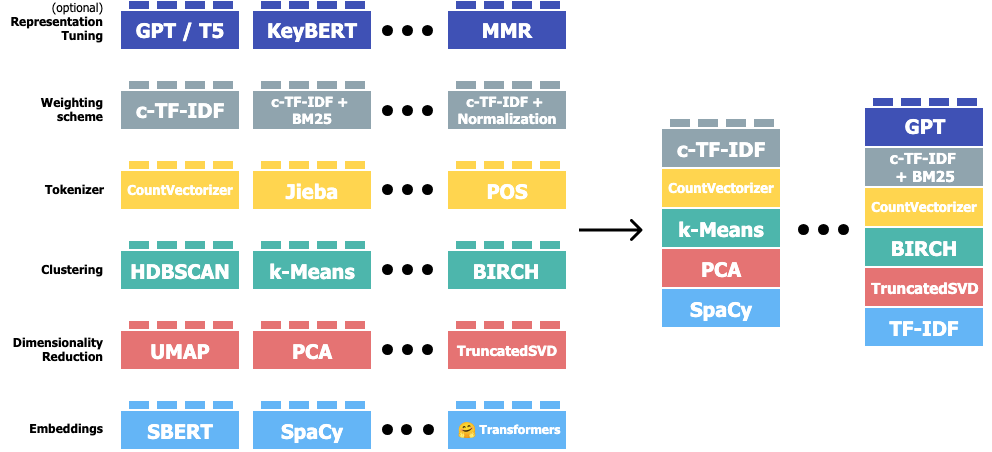

# Overview of Algorithm

## Code Overview of BERTopic's Algorithm



The BERTopic algorithm is comprised of several distinct steps, each of which plays a crucial role in the topic modeling process. This code overview demonstrates how to explicitly define each step when using BERTopic, enhancing the transparency and intuitiveness of the process.

```python
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with a `bertopic.representation` model
representation_model = KeyBERTInspired()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic represenations
)
```

Step 1 (Extract embeddings): Utilizes SentenceTransformer for converting text into embeddings.

Step 2 (Reduce dimensionality): Applies UMAP to reduce the dimensionality of the embeddings.

Step 3 (Cluster reduced embeddings): Uses HDBSCAN for clustering the dimensionality-reduced embeddings.

Step 4 (Tokenize topics): Tokenizes topics using CountVectorizer.

Step 5 (Create topic representation): Employs ClassTfidfTransformer to create a topic representation.

Step 6 (Optional Fine-tune topic representations): Optionally, fine-tune topic representations with a KeyBERTInspired model for enhanced topic clarity.

## Detailed Overview

### 1. **Embed documents**

We start by **converting our documents to numerical representations**. Although there are many methods for doing so the default in BERTopic is sentence-transformers. These models are often optimized for semantic similarity which helps tremendously in our clustering task. Moreover, they are great for creating either document- or sentence-embeddings.
In BERTopic, you can choose any sentence-transformers model but two models are set as defaults:

- `"all-MiniLM-L6-v2"`

- `"paraphrase-multilingual-MiniLM-L12-v2"`

The first is an English language model trained specifically for semantic similarity tasks which works quite well for most use cases. The second model is very similar to the first with one major difference being that the multilingual models work for 50+ languages. This model is quite a bit larger than the first and is only selected if you select any language other than English.

### 2. **Dimensionality reduction**

After having created our numerical representations of the documents we have to reduce the dimensionality of these representations. Cluster models typically have difficulty handling high dimensional data due to the curse of dimensionality. There are great approaches that can reduce dimensionality, such as PCA, but as a default UMAP is selected in BERTopic. It is a technique that can keep some of a dataset's local and global structure when reducing its dimensionality. This structure is important to keep as it contains the information necessary to create clusters of semantically similar documents.

    Tip: Although BERTopic uses UMAP as a default, you can choose any dimensionality reduction model that fits your use case. Follow the guide here for selecting and customizing your model.

### 3. Cluster Documents¶
After having reduced our embeddings, we can start clustering our data. For that, we leverage a density-based clustering technique, HDBSCAN. It can find clusters of different shapes and has the nice feature of identifying outliers where possible. As a result, we do not force documents into a cluster where they might not belong. This will improve the resulting topic representation as there is less noise to draw from.

    Tip: Although BERTopic uses HDBSCAN as a default, you can choose any cluster model that fits your use case. Follow the guide here for selecting and customizing your model.

### 4. **Bag-of-words**
Before we can start creating the topic representation we first need to select a technique that allows for modularity in BERTopic's algorithm. 

When we use HDBSCAN as a cluster model, we may assume that our clusters have different degrees of density and different shapes. This means that a centroid-based topic representation technique might not be the best-fitting model. In other words, we want a topic representation technique that makes little to no assumption on the expected structure of the clusters.


To do this, we first combine all documents in a cluster into a single document. That, very long, document then represents the cluster. Then, we can count how often each word appears in each cluster. This generates something called a bag-of-words representation in which the frequency of each word in each cluster can be found. This bag-of-words representation is therefore on a cluster level and not on a document level. This distinction is important as we are interested in words on a topic level (i.e., cluster level). By using a bag-of-words representation, no assumption is made concerning the structure of the clusters. Moreover, the bag-of-words representation is L1-normalized to account for clusters that have different sizes.

    Tip: There are many ways you can tune or change the bag-of-words step. This step allows for processing the documents however you want without affecting the first step, embedding the documents. You can follow the guide here for more information about tokenization options in BERTopic.


### 5. **Topic representation**
From the generated bag-of-words representation, we want to know what makes one cluster different from another. Which words are typical for cluster 1 and not so much for all other clusters? To solve this, we need to modify TF-IDF such that it considers topics (i.e., clusters) instead of documents.

When you apply TF-IDF as usual on a set of documents, what you are doing is comparing the importance of words between documents. Now, what if, we instead treat all documents in a single category (e.g., a cluster) as a single document and then apply TF-IDF? The result would be importance scores for words within a cluster. The more important words are within a cluster, the more it is representative of that topic. In other words, if we extract the most important words per cluster, we get descriptions of topics! This model is called class-based TF-IDF:

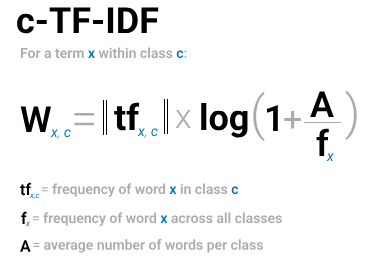

Each cluster is converted to a single document instead of a set of documents. Then, we extract the frequency of word x in class c, where c refers to the cluster we created before. This results in our class-based tf representation. This representation is L1-normalized to account for the differences in topic sizes.

Then, we take the logarithm of one plus the average number of words per class A divided by the frequency of word x across all classes. We add plus one within the logarithm to force values to be positive. This results in our class-based idf representation. Like with the classic TF-IDF, we then multiply tf with idf to get the importance score per word in each class. In other words, the classical TF-IDF procedure is not used here but a modified version of the algorithm that allows for a much better representation.



### **6. (Optional) Fine-tune Topic representation**

After having generated the c-TF-IDF representations, we have a set of words that describe a collection of documents. c-TF-IDF is a method that can quickly generate accurate topic representations. However, with the fast developments in NLP-world, new and exciting methods are released weekly. In order to keep up with what is happening, there is the possibility to further fine-tune these c-TF-IDF topics using GPT, T5, KeyBERT, Spacy, and other techniques. Many are implemented in BERTopic for you to use and play around with.

More specifically, we can consider the c-TF-IDF generated topics to be candidate topics. They each contain a set of keywords and representative documents that we can use to further fine-tune the topic representations. Having a set of representative documents for each topic is huge advantage as it allows for fine-tuning on a reduced number of documents. This reduces computation for large models as they only need to operate on that small set of representative documents for each topic. As a result, large language models like GPT and T5 becomes feasible in production settings and typically take less wall time than the dimensionality reduction and clustering steps.

# Testing the BERTopic Code

In [ ]:
# Importing data
import pandas as pd
from bertopic import BERTopic

In [ ]:
# df = pd.read_csv('data/positive_question.csv')
df = pd.read_csv('data/positive_question_8k.csv')

df = df.drop(columns=["Unnamed: 0"])
df = df.dropna(subset=["comment"])

pd.set_option('display.max_colwidth', 5000)
df.head()


In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, )
# topics, probs = topic_model.fit_transform(df['Q1'])
topics, probs = topic_model.fit_transform(df['comment'])

### Extracting Topics

In [ ]:
freq = topic_model.get_topic_info(); freq.head(20)

## Visualize Topics
After having trained our `BERTopic` model, we can iteratively go through perhaps a hundred topic to get a good
understanding of the topics that were extract. However, that takes quite some time and lacks a global representation.
Instead, we can visualize the topics that were generated in a way very similar to
[LDAvis](https://github.com/cpsievert/LDAvis):

In [ ]:
topic_model.visualize_topics()

## Visualize Topic Probabilities

The variable `probabilities` that is returned from `transform()` or `fit_transform()` can
be used to understand how confident BERTopic is that certain topics can be found in a document.

To visualize the distributions, we simply call:

In [ ]:
topic_model.visualize_distribution(probs[1100], min_probability=0.015)

## Visualize Topic Hierarchy



The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. This might help selecting an appropriate nr_topics when reducing the number of topics that you have created.

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

## Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [ ]:
topic_model.visualize_barchart(top_n_topics=20)

## Visualize Topic Similarity
Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [ ]:
topic_model.visualize_heatmap(n_clusters=2, width=1000, height=1000)

# Test 2 With New Parameters

In [ ]:
# Importing data
import pandas as pd
from bertopic import BERTopic


In [ ]:
# df = pd.read_csv('data/positive_question.csv')
df = pd.read_csv('data/positive_question_8k.csv')
df = df.drop(columns=["Unnamed: 0"])
df = df.dropna(subset=["comment"])


In [ ]:
df.info()

In [ ]:
import pandas as pd
import re

def replace_words_in_comments(df, replacements):
    """
    Replaces specified words or combinations of words in the 'comment' column of a DataFrame.

    Parameters:
    - df: pandas.DataFrame with a 'comment' column.
    - replacements: A dictionary where keys are words or phrases to replace (accepts regex),
                    and values are the replacement words.

    Returns:
    - A pandas.DataFrame with the replacements made.
    """
    # Ensure the 'comment' column is a string to avoid errors with replacement
    df['comment'] = df['comment'].astype(str)
    
    # Apply replacements
    for target, replacement in replacements.items():
        df['comment'] = df['comment'].apply(lambda x: re.sub(target, replacement, x, flags=re.IGNORECASE))

    return df

# Example usage
replacements = {
    'AI Singapore': 'my organization', 'ai singapore': 'my organization' 
    # Add more replacements as needed
}

# Assuming your DataFrame is named df
df = replace_words_in_comments(df, replacements)


In [ ]:
# UMAP for reducing dimensionality
from umap import UMAP
umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', low_memory=False)

# n_neighbors¶
# n_neighbors is the number of neighboring sample points used when making the manifold approximation. 
# Increasing this value typically results in a more global view of the embedding structure whilst smaller values result in a more local view. 
# Increasing this value often results in larger clusters being created.

# n_components¶
# n_components refers to the dimensionality of the embeddings after reducing them. This is set as a default to 5 to reduce dimensionality as much as possible whilst trying to maximize the information kept in the resulting embeddings. 
# Although lowering or increasing this value influences the quality of embeddings, its effect is largest on the performance of HDBSCAN. Increasing this value too much and HDBSCAN will have a hard time clustering the high-dimensional embeddings. Lower this value too much and too little information in the resulting embeddings are available to create proper clusters. If you want to increase this value, I would advise setting using a metric for HDBSCAN that works well in high dimensional data.

# metric¶
# metric refers to the method used to compute the distances in high dimensional space. The default is cosine as we are dealing with high dimensional data. However, BERTopic is also able to use any input, even regular tabular data, to cluster the documents. Thus, you might want to change the metric to something that fits your use case.

# low_memory¶
# low_memory is used when datasets may consume a lot of memory. Using millions of documents can lead to memory issues and setting this value to True might alleviate some of the issues.

# HDBSCAN for clustering documents
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True)

# min_cluster_size¶
# min_cluster_size is arguably the most important parameter in HDBSCAN. It controls the minimum size of a cluster and thereby the number of clusters that will be generated. It is set to 10 as a default. 
# Increasing this value results in fewer clusters but of larger size whereas decreasing this value results in more micro clusters being generated. Typically, I would advise increasing this value rather than decreasing it.

# min_samples¶
# min_samples is automatically set to min_cluster_size and controls the number of outliers generated. 
# Setting this value significantly lower than min_cluster_size might help you reduce the amount of noise you will get. Do note that outliers are to be expected and forcing the output to have no outliers may not properly represent the data.

# metric¶
# metric, like with HDBSCAN is used to calculate the distances. Here, we went with euclidean as, after reducing the dimensionality, we have low dimensional data and not much optimization is necessary. 
# However, if you increase n_components in UMAP, then it would be advised to look into metrics that work with high dimensional data.

# prediction_data¶
# Make sure you always set this value to True as it is needed to predict new points later on. You can set this to False if you do not wish to predict any unseen data points.

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, umap_model=umap_model, hdbscan_model=hdbscan_model, nr_topics = 15)
# topics, probs = topic_model.fit_transform(df['Q1'])
topics, probs = topic_model.fit_transform(df['comment'])

### Extracting Topics

In [ ]:
freq = topic_model.get_topic_info(); freq.head(20)

## Visualize Topics
After having trained our `BERTopic` model, we can iteratively go through perhaps a hundred topic to get a good
understanding of the topics that were extract. However, that takes quite some time and lacks a global representation.
Instead, we can visualize the topics that were generated in a way very similar to
[LDAvis](https://github.com/cpsievert/LDAvis):

In [ ]:
topic_model.visualize_topics()

## Visualize Topic Probabilities

The variable `probabilities` that is returned from `transform()` or `fit_transform()` can
be used to understand how confident BERTopic is that certain topics can be found in a document.

To visualize the distributions, we simply call:

In [ ]:
topic_model.visualize_distribution(probs[1100], min_probability=0.015)

## Visualize Topic Hierarchy



The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. This might help selecting an appropriate nr_topics when reducing the number of topics that you have created.

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

## Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [ ]:
topic_model.visualize_barchart(top_n_topics=20)

## Visualize Topic Similarity
Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [ ]:
topic_model.visualize_heatmap(n_clusters=2, width=1000, height=1000)

# Testing with new parameters

In [ ]:
# Testing with new parameters

# Representation model
from bertopic.representation import KeyBERTInspired
representation_model = KeyBERTInspired()
# Use the representation model in BERTopic on top of the default pipeline
# topic_model = BERTopic(representation_model=representation_model)

# UMAP for reducing dimensionality
from umap import UMAP
umap_model = UMAP(n_neighbors=15, n_components=10, metric='cosine', low_memory=False)
#HDBSCAN
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True)


# Setting topic_model parameters
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, umap_model=umap_model, hdbscan_model=hdbscan_model, nr_topics = 15, representation_model=representation_model)

# Executing topic model
# topics, probs = topic_model.fit_transform(df['Q1'])
topics, probs = topic_model.fit_transform(df['comment'])


### Extracting Topics
freq = topic_model.get_topic_info(); freq.head(20)


In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
topic_model.visualize_barchart(top_n_topics=20)

# New objective: Comparing Parameters

In [ ]:
# 1st combination


# Importing libraries
from bertopic.representation import KeyBERTInspired
from umap import UMAP
from hdbscan import HDBSCAN


representation_model_1 = KeyBERTInspired(nr_repr_docs=10)
umap_model_1 = UMAP(n_neighbors=5, n_components=10, metric='cosine', low_memory=False)
hdbscan_model_1 = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True)


# 12 topics
topic_model_1 = BERTopic(language="english", calculate_probabilities=True, 
                       verbose=True, 
                       umap_model=umap_model_1, 
                       hdbscan_model=hdbscan_model_1, 
                       nr_topics = 15, 
                       representation_model=representation_model_1
                       )

topics, probs = topic_model_1.fit_transform(df['comment'])


# Topic Model 1 
freq = topic_model_1.get_topic_info(); freq.head(3)


In [ ]:
# Combination 2


# Importing libraries
from bertopic.representation import KeyBERTInspired
from umap import UMAP
from hdbscan import HDBSCAN


representation_model_2 = KeyBERTInspired(nr_repr_docs=10)
umap_model_2 = UMAP(n_neighbors=30, n_components=5, metric='cosine', low_memory=False)
hdbscan_model_2 = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True) 


# 12 topics
topic_model_2 = BERTopic(language="english", calculate_probabilities=True, 
                       verbose=True, 
                       umap_model=umap_model_2, 
                       hdbscan_model=hdbscan_model_2, 
                       nr_topics = 15, 
                       representation_model=representation_model_2
                       )

topics, probs = topic_model_2.fit_transform(df['comment'])


# Topic Model 1 
freq = topic_model_2.get_topic_info(); freq.head(10)


In [ ]:
# Importing libraries
from bertopic.representation import KeyBERTInspired
from umap import UMAP
from hdbscan import HDBSCAN


representation_model_3 = KeyBERTInspired(nr_repr_docs=10)
umap_model_3 = UMAP(n_neighbors=5, n_components=30, metric='cosine', low_memory=False) # Increasing n_components
hdbscan_model_3 = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True) 


# 12 topics
topic_model_3 = BERTopic(language="english", calculate_probabilities=True, 
                       verbose=True, 
                       umap_model=umap_model_3, 
                       hdbscan_model=hdbscan_model_3, 
                    #  nr_topics = 20, 
                       representation_model=representation_model_3
                       )

topics, probs = topic_model_3.fit_transform(df['comment'])


# Topic Model 1 
freq = topic_model_3.get_topic_info(); freq.head(50)

In [ ]:
# Combination 3


# Importing libraries
from bertopic.representation import KeyBERTInspired
from umap import UMAP
from hdbscan import HDBSCAN


representation_model_3 = KeyBERTInspired(nr_repr_docs=10)
umap_model_3 = UMAP(n_neighbors=50, n_components=30, metric='cosine', low_memory=False) # Increasing n_components
hdbscan_model_3 = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True) 


# 12 topics
topic_model_3 = BERTopic(language="english", calculate_probabilities=True, 
                       verbose=True, 
                       umap_model=umap_model_3, 
                       hdbscan_model=hdbscan_model_3, 
                    #  nr_topics = 20, 
                       representation_model=representation_model_3
                       )

topics, probs = topic_model_3.fit_transform(df['comment'])


# Topic Model 1 
freq = topic_model_3.get_topic_info(); freq.head(50)


In [ ]:
# Combination 5 - adjusting smaller n_components, with about 25 n_neighbors


# Importing libraries
from bertopic.representation import KeyBERTInspired
from umap import UMAP
from hdbscan import HDBSCAN


representation_model_3 = KeyBERTInspired(nr_repr_docs=10)
umap_model_3 = UMAP(n_neighbors=25, n_components=5, metric='cosine', low_memory=False) # Decreasing n_components
hdbscan_model_3 = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True) 


# 12 topics
topic_model_3 = BERTopic(language="english", calculate_probabilities=True, 
                       verbose=True, 
                       umap_model=umap_model_3, 
                       hdbscan_model=hdbscan_model_3, 
                    #  nr_topics = 20, 
                       representation_model=representation_model_3
                       )

topics, probs = topic_model_3.fit_transform(df['comment'])


# Topic Model 1 
freq = topic_model_3.get_topic_info(); freq.head(50)


In [ ]:
# Combination 6 - adjusting larger n_components, with about 25 n_neighbors


# Importing libraries
from bertopic.representation import KeyBERTInspired
from umap import UMAP
from hdbscan import HDBSCAN


representation_model_3 = KeyBERTInspired(nr_repr_docs=10)
umap_model_3 = UMAP(n_neighbors=25, n_components=50, metric='cosine', low_memory=False) # Decreasing n_components
hdbscan_model_3 = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True) 


# 12 topics
topic_model_3 = BERTopic(language="english", calculate_probabilities=True, 
                       verbose=True, 
                       umap_model=umap_model_3, 
                       hdbscan_model=hdbscan_model_3, 
                    #  nr_topics = 20, 
                       representation_model=representation_model_3
                       )

topics, probs = topic_model_3.fit_transform(df['comment'])


# Topic Model 1 
freq = topic_model_3.get_topic_info(); freq.head(50)


Conclusions: 

- Setting the n_neighbors larger is quite useful in creating different bins, rather than relying on the nr_topics parameter, which uses a TF-IDF calculation. This is important because we want to be able to capture nuances with smaller n_neighbors, but we don't want it to be cascaded by the TF-IDF metric

- n_components should be the metric that is used to capture smaller level information, as compared to creating higher level bins. 

General information capturing = smaller n_components as 5
More granularity = increasing n_components to 30

# New section - subsetting and modelling subset

## Best combination: 5

In [ ]:
df_topics = df.copy()

In [ ]:
# Importing libraries
from bertopic.representation import KeyBERTInspired
from umap import UMAP
from hdbscan import HDBSCAN


representation_model_3 = KeyBERTInspired(nr_repr_docs=10)
umap_model_3 = UMAP(n_neighbors=25, n_components=5, metric='cosine', low_memory=False) # Decreasing n_components
hdbscan_model_3 = HDBSCAN(min_cluster_size=10, metric='euclidean', prediction_data=True) 


# 12 topics
topic_model_3 = BERTopic(language="english", calculate_probabilities=True, 
                       verbose=True, 
                       umap_model=umap_model_3, 
                       hdbscan_model=hdbscan_model_3, 
                        nr_topics = 20, 
                       representation_model=representation_model_3
                       )

topics, probs = topic_model_3.fit_transform(df['comment'])


# Topic Model 1 
freq = topic_model_3.get_topic_info(); freq

Step 1: Adjusting the Original Script to Add a Topics Column
After you run fit_transform with the BERTopic model, you get topics, which is a list where each element corresponds to the topic of the respective document in your input dataset. Here's how you can add this information back to your original dataframe:

In [ ]:
# Assuming df is your original dataframe and it's indexed properly
df_topics['topic'] = topics

In [ ]:
df_topics

In [ ]:
# Subsetting comments from topic -1
topic_minus_one_comments = df_topics[df_topics['topic'] == -1]['comment']

# Splitting comments into sentences
sentences = topic_minus_one_comments.str.split('.').explode().str.strip()

# Removing empty strings
sentences = sentences[sentences != '']

# Converting sentences to a new dataframe to run the model again
new_df = pd.DataFrame(sentences, columns=['comment']).reset_index(drop=True)

In [ ]:
topics_new, probs_new = topic_model_3.fit_transform(new_df['comment'])

# Adding topics to the new dataframe
new_df['topic'] = topics_new

# Getting topic information
freq_new = topic_model_3.get_topic_info()

In [ ]:
freq_new